In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from utils import *
from filters import LKF_CA
from measurement import MeasMixDoppler, MeasMixPositionOnly
from simulation import *

# TODO: 
# 2. Compare different measurement functions
#    1.2 What about measurement conversion?
#    1.3 What if we try Linear Kalman filter? Will it diverge?

In [2]:
def plot_xy(ax, meas, truth):
    ax.plot(meas[0, :], meas[1, :], '*', label='meas')
    ax.plot(truth[IX, :], truth[IY, :], 'k--', label='truth')
    ax.legend()
    ax.grid()
    ax.set_xlabel('Pos. X (m)')
    ax.set_ylabel('Pos. Y (m)')

def plot_eval(fig, options: list, filters: list, frame_vec, data_kf, data_meas=None, data_truth=None):
    gs = fig.add_gridspec(3, 2)
    for p in options:
        ax = fig.add_subplot(gs[*p['grid_pos']])
        # filters
        for j, filt in enumerate(filters):
            ax.plot(frame_vec, data_kf[j, p['index'], :], '-', label=filt['label'], linewidth=2)
        # measurements
        if p.get('meas_index', None) is not None:
            ax.plot(frame_vec, data_meas[p['meas_index'], :], '.', label='measurement', linewidth=2)
        # truth
        if data_truth is not None:
            ax.plot(frame_vec, data_truth[p['index'], :], 'k--', label='truth', linewidth=2)
        ax.set_ylabel(p['ylabel'])
        ax.legend()
        ax.grid()

In [19]:
T = 0.1  # time between cycles
dim_state = 6 # dimension of state
dim_meas = 3 # dimension of measurements
std_r, std_phi, std_doppler = 0.5, np.radians(5), 0.1

# defining scenario
n_frames = int(20/T)
frame_vec = np.arange(n_frames)
x_init = np.array([1, 0, 5, 0.5, 0, 0])
ax_periods = [2/T, 4/T, -3]
ay_periods = [0, 0, 0]

# truth motion
F_sim = LKF_CA.get_state_transition(T)
sim_state = simulate_motion(F_sim, dim_state, n_frames, x_init, ax_periods, ay_periods)


SEED = 0
np.random.seed(SEED)
n_iter = 50
filters = [
    {'kf': LKF_CA, 'meas_fn': MeasMixPositionOnly(std_r, std_phi), 'label': 'pos-only'},
    {'kf': LKF_CA, 'meas_fn': MeasMixDoppler(std_r, std_phi, std_doppler), 'label': 'doppler'},
    {'kf': LKF_CA, 'meas_fn': MeasMixDoppler(std_r, std_phi, 3*std_doppler), 'label': '3 doppler'},
]
n_filters = len(filters)

# run
kf_errors = np.zeros((n_filters, n_iter, dim_state, n_frames))
kf_mean_state = np.zeros((n_filters, dim_state, n_frames))
meas_mean_pos = np.zeros((2, n_frames)) # x, y
for i, filt in enumerate(filters):
    kf = filt['kf'](cycle_time = T, meas_fn = filt['meas_fn'])

    for k in range(n_iter):
        # simulating measurements
        meas = simulate_measurements(sim_state, std_r, std_phi, std_doppler)

        # applying KF
        kf_state = np.zeros_like(sim_state)
        for frame in range(n_frames):
            z = meas[[IR, IT, ID], frame]
            if frame==0:
                # initializing KF
                x0, y0 = meas[[IMX, IMY], frame]
                state_init = np.array([x0, y0, 0, 0, 0, 0])
                kf.initialize_filter(state_init)
            else:
                kf.predict()
                kf.update(z, compute_lk=False)
                kf_state[:, frame] = kf.x
        if i==0:
            # only evalute once
            meas_mean_pos += 1/n_iter * meas[[IMX, IMY], :]

        # evaluating KF
        kf_mean_state[i, :, :] += 1/n_iter * kf_state
        kf_errors[i, k, :, :] = kf_state - sim_state
        
rms_error = np.sqrt(np.mean(kf_errors**2, axis=1))

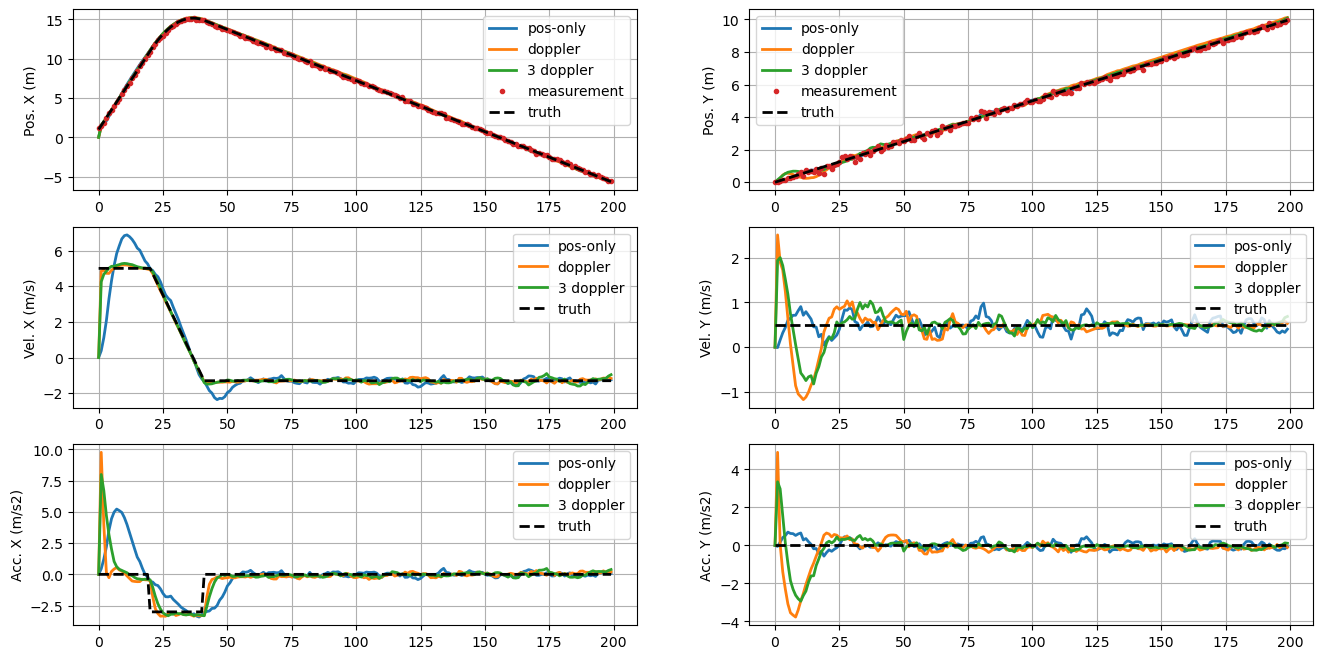

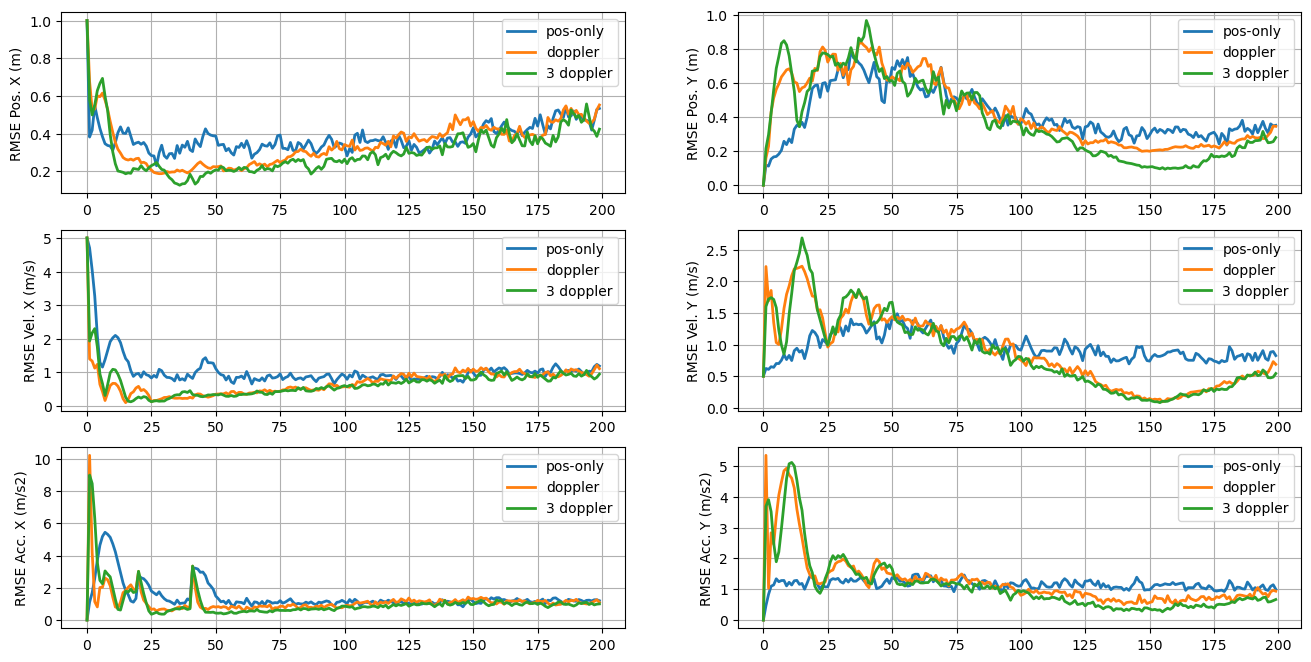

In [21]:
# error viewer

# mean state
options_mean_state = [
    {'grid_pos': (0, 0), 'index': IX, 'ylabel': 'Pos. X (m)', 'meas_index': 0},
    {'grid_pos': (0, 1), 'index': IY, 'ylabel': 'Pos. Y (m)', 'meas_index': 1},
    {'grid_pos': (1, 0), 'index': IVX, 'ylabel': 'Vel. X (m/s)'},
    {'grid_pos': (1, 1), 'index': IVY, 'ylabel': 'Vel. Y (m/s)'},
    {'grid_pos': (2, 0), 'index': IAX, 'ylabel': 'Acc. X (m/s2)'},
    {'grid_pos': (2, 1), 'index': IAY, 'ylabel': 'Acc. Y (m/s2)'},
]
fig = plt.figure(figsize=(16, 8))
plot_eval(fig, options_mean_state, filters, frame_vec, kf_mean_state, meas_mean_pos, sim_state)

# RMS errors
options_rms_errors = [
    {'grid_pos': (0, 0), 'index': IX, 'ylabel': 'RMSE Pos. X (m)'},
    {'grid_pos': (0, 1), 'index': IY, 'ylabel': 'RMSE Pos. Y (m)'},
    {'grid_pos': (1, 0), 'index': IVX, 'ylabel': 'RMSE Vel. X (m/s)'},
    {'grid_pos': (1, 1), 'index': IVY, 'ylabel': 'RMSE Vel. Y (m/s)'},
    {'grid_pos': (2, 0), 'index': IAX, 'ylabel': 'RMSE Acc. X (m/s2)'},
    {'grid_pos': (2, 1), 'index': IAY, 'ylabel': 'RMSE Acc. Y (m/s2)'},
]
fig = plt.figure(figsize=(16, 8))
plot_eval(fig, options_rms_errors, filters, frame_vec, rms_error)

# XY plot
# fig, ax = plt.subplots(figsize=(10, 8))
# plot_xy(ax, meas_mean_pos, sim_state)
# for j, filt in enumerate(filters):
#     ax.plot(kf_mean_state[j, IX, :], kf_mean_state[j, IY, :], '-', label=filt['label'])
# ax.legend()

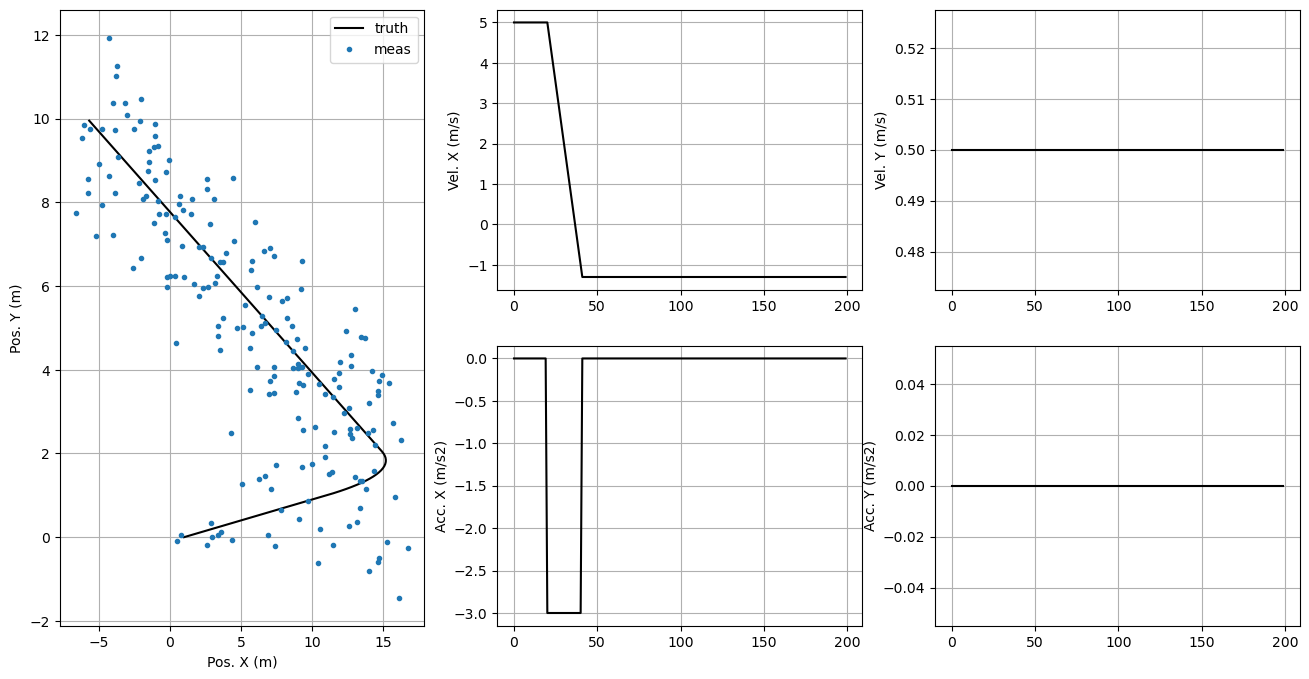

In [16]:
# scenario viewer
plot_options = [
    {'grid_pos': (0, 1), 'index': IVX, 'ylabel': 'Vel. X (m/s)'},
    {'grid_pos': (0, 2), 'index': IVY, 'ylabel': 'Vel. Y (m/s)'},
    {'grid_pos': (1, 1), 'index': IAX, 'ylabel': 'Acc. X (m/s2)'},
    {'grid_pos': (1, 2), 'index': IAY, 'ylabel': 'Acc. Y (m/s2)'},
]

fig = plt.figure(figsize=(16, 8))
gs = fig.add_gridspec(2, 3)
# X-Y plot
ax1 = fig.add_subplot(gs[:, 0])
ax1.plot(sim_state[IX, :], sim_state[IY, :], 'k-', label='truth')
ax1.plot(meas[IMX, :], meas[IMY], '.', label='meas')
ax1.legend()
ax1.grid()
ax1.set_xlabel('Pos. X (m)')
ax1.set_ylabel('Pos. Y (m)')
for p in plot_options:
    ax = fig.add_subplot(gs[*p['grid_pos']])
    ax.plot(frame_vec, sim_state[p['index'], :], 'k-', label='truth')
    ax.set_ylabel(p['ylabel'])
    ax.grid()